In [ ]:
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
  
  
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [ ]:
#This part linkes the dataset in the drive to the google colab file
link = 'https://drive.google.com/file/d/1GEsalW5I7kD50HaBdUgUZSk1d3qBM1Z5/view?usp=sharing'
id = link.split('/')[-2]
downloaded = drive.CreateFile({'id' : id})
downloaded.GetContentFile('StockPrices.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('StockPrices.csv')
df['Date']= pd.to_datetime(df['Date'])
df_close = df[['Date', 'Index', 'Close']] 
df_close.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275516 entries, 0 to 2275515
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   Index   object        
 2   Close   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 52.1+ MB


In [ ]:
#Closing Prices Dataframe
df_close = df_close.pivot_table(index = 'Date', columns = 'Index', values='Close').dropna(axis=1)
df_close.head()

Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-11-03,33.485336,0.397321,10.171875,28.87500,23.679522,40.34375,62.3125,10.297619,50.904800,5.343750,40.8125,41.3750,61.2500,17.484375,1898.75,44.0000,30.00000,53.9375,10.06250,6.640625,36.5625,26.609375,24.71875,23.7500,3.240741,59.8125,41.8750,37.5625,2.90625,30.0625,2.656250,24.215368,33.244682,8.125000,33.500,23.6250,1.083333,45.6875,50.6875,52.189762,...,2.2500,9.6250,20.187500,13.265625,27.7500,12.062500,60.5625,19.0000,19.7500,11.934061,6.635476,7.783935,42.5625,25.469130,142.375000,93.875000,5.352860,51.261398,4.90625,74.4375,44.0000,5.9375,9.43750,17.2500,23.25000,43.1875,20.6875,30.963131,47.3750,4.592593,5.437500,45.3750,25.7500,71.4375,43.75000,11.708333,25.032938,5.391805,20.194445,57.4375
2000-11-06,33.172390,0.382813,10.234375,29.00000,23.623409,41.62500,62.0000,10.357142,51.648300,5.500000,40.8750,41.3750,62.8125,17.890625,1956.25,44.5625,29.56250,56.5000,10.50000,6.703125,37.0000,27.218750,24.65625,24.3125,3.222222,59.8750,41.0625,36.5625,2.93750,30.1875,2.656250,23.917749,32.955597,8.015625,33.500,23.6250,1.145833,45.8750,50.6875,53.065063,...,2.1250,9.6875,20.171875,13.632813,28.0000,12.156250,60.0000,18.9375,19.8750,11.303789,6.635476,7.898195,42.6250,25.514854,143.265625,91.687500,5.210118,49.968620,4.93750,74.6250,43.9375,5.9375,9.40625,16.9375,23.40625,42.9375,21.6250,31.243763,49.0000,4.683127,5.375000,44.4375,25.8750,72.8750,44.34375,11.916667,25.527010,5.492901,20.055555,57.8750
2000-11-07,32.859444,0.380580,10.484375,27.62500,23.483128,41.12500,53.9375,10.416667,51.450031,5.562500,40.7500,40.9375,64.1875,17.562500,1987.50,44.4375,30.12500,57.7500,10.75000,6.593750,37.1875,27.406250,23.43750,22.5625,3.259259,61.8125,39.2500,36.9375,2.81250,31.1250,2.687500,24.080086,33.302498,7.945313,33.875,23.6875,1.145833,45.9375,50.8750,53.338593,...,2.0625,9.6250,21.640625,13.593750,27.9375,12.031250,59.9375,18.6250,19.3750,12.084778,6.591337,7.955325,42.6875,25.514854,139.750000,96.859375,5.566975,49.406544,5.00000,73.8125,43.2500,5.8125,9.31250,17.0625,23.25000,42.8125,23.0625,32.132431,48.9375,4.691358,5.406250,44.0625,25.6875,66.6875,44.50000,12.062500,25.856390,5.481668,20.388889,57.3750
2000-11-08,31.741774,0.358259,11.125000,27.12500,23.567297,40.12500,46.9375,10.476191,51.400467,5.625000,40.8750,40.6250,63.5000,17.437500,1977.50,44.7500,30.06250,52.0000,11.03125,6.640625,38.2500,27.421875,21.71875,21.6875,3.240741,61.6250,40.4375,33.8750,2.87500,29.9375,2.687500,24.296537,33.765034,8.015625,34.500,23.3750,1.114583,45.6875,51.5000,50.767399,...,2.0000,9.6250,21.390625,13.812500,28.9375,11.921875,59.7500,19.5625,19.2500,12.276600,6.753178,7.769653,43.3750,25.652031,127.125000,93.250000,5.781089,49.518959,4.90625,71.7500,42.8750,6.0000,9.37500,17.1250,23.46875,42.6250,24.4375,32.787243,48.7500,4.691358,5.265625,43.8750,25.7500,58.3125,45.34375,12.104167,25.032938,5.436736,20.027779,57.7500
2000-11-09,31.160587,0.360491,11.468750,27.28125,23.511183,41.59375,45.8750,10.476191,51.549168,5.484375,41.6875,41.2500,62.4375,18.250000,2010.00,44.5000,30.21875,50.8750,10.90625,6.578125,38.5625,24.718750,21.68750,21.0000,3.166667,62.7500,39.1250,31.2500,2.75000,30.0000,2.677083,24.053030,33.302498,7.796875,35.750,23.9375,1.125000,45.6250,50.5625,50.986225,...,2.0000,9.6250,21.734375,14.203125,29.3125,12.078125,58.6250,18.4375,19.3125,11.728538,6.753178,7.955325,42.9375,25.606306,123.062500,91.000000,5.781089,50.362076,5.00000,71.0000,43.0625,5.7500,9.50000,16.9375,23.90625,41.0625,24.5000,31.664711,47.1250,4.740741,5.187500,43.1875,26.0000,62.9375,44.93750,12.104167,23.221344,5.459202,20.583334

In [ ]:
#Calculation of the Log Returns
df_returns = (df_close.apply(lambda x: np.log(x) - np.log(x.shift(1)))).iloc[1:]
df_returns.head() 

Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-11-06,-0.009390,-0.037198,0.006126,0.004320,-0.002372,0.031264,-0.005028,0.005764,0.014500,0.028820,0.001530,0.000000,0.025190,0.022969,0.029834,0.012703,-0.014691,0.046415,0.042560,0.009368,0.011895,0.022642,-0.002532,0.023408,-0.005731,0.001044,-0.019594,-0.026983,0.010695,0.004149,0.000000,-0.012367,-0.008734,-0.013553,0.000000,0.000000,0.056089,0.004096,0.000000,0.016632,...,-0.057158,0.006473,-0.000774,0.027304,0.008969,0.007742,-0.009331,-0.003295,0.006309,-0.054259,0.000000,0.014572,0.001467,0.001794,0.006236,-0.023578,-0.027028,-0.025543,0.006349,0.002516,-0.001421,0.000000,-0.003317,-0.018282,0.006698,-0.005806,0.044320,0.009023,0.033726,0.019521,-0.011561,-0.020878,0.004843,0.019923,0.013480,0.017637,0.019545,0.018576,-0.006901,0.007588
2000-11-07,-0.009479,-0.005850,0.024134,-0.048575,-0.005956,-0.012085,-0.139308,0.005731,-0.003846,0.011300,-0.003063,-0.010630,0.021654,-0.018511,0.015848,-0.002809,0.018849,0.021883,0.023530,-0.016452,0.005055,0.006865,-0.050693,-0.074701,0.011429,0.031847,-0.045144,0.010204,-0.043485,0.030583,0.011696,0.006764,0.010471,-0.008811,0.011132,0.002642,0.000000,0.001361,0.003692,0.005141,...,-0.029853,-0.006473,0.070283,-0.002869,-0.002235,-0.010336,-0.001042,-0.016639,-0.025479,0.066809,-0.006674,0.007207,0.001465,0.000000,-0.024845,0.054874,0.066249,-0.011312,0.012579,-0.010947,-0.015771,-0.021277,-0.010017,0.007353,-0.006698,-0.002915,0.064358,0.028046,-0.001276,0.001756,0.005797,-0.008475,-0.007273,-0.088728,0.003517,0.012163,0.012821,-0.002047,0.016484,-0.008677
2000-11-08,-0.034606,-0.060440,0.059309,-0.018265,0.003578,-0.024617,-0.139009,0.005698,-0.000964,0.011173,0.003063,-0.007663,-0.010769,-0.007143,-0.005044,0.007008,-0.002077,-0.104880,0.025826,0.007084,0.028171,0.000570,-0.076161,-0.039553,-0.005698,-0.003038,0.029806,-0.086550,0.021979,-0.038899,0.000000,0.008949,0.013793,0.008811,0.018282,-0.013280,-0.027652,-0.005457,0.012210,-0.049406,...,-0.030772,0.000000,-0.011620,0.015964,0.035168,-0.009132,-0.003133,0.049110,-0.006473,0.015748,0.024257,-0.023616,0.015977,0.005362,-0.094684,-0.037976,0.037740,0.002273,-0.018928,-0.028340,-0.008708,0.031749,0.006689,0.003656,0.009365,-0.004389,0.057911,0.020174,-0.003839,0.000000,-0.026356,-0.004264,0.002430,-0.134201,0.018783,0.003448,-0.032365,-0.008231,-0.017870,0.006515
2000-11-09,-0.018480,0.006211,0.030431,0.005744,-0.002384,0.035950,-0.022897,0.000000,0.002889,-0.025318,0.019683,0.015267,-0.016874,0.045542,0.016301,-0.005602,0.005184,-0.021872,-0.011396,-0.009456,0.008137,-0.103779,-0.001440,-0.032214,-0.023122,0.018091,-0.032996,-0.080658,-0.044452,0.002086,-0.003884,-0.010073,-0.013793,-0.027670,0.035591,0.023779,0.009303,-0.001369,-0.018372,0.004301,...,0.000000,0.000000,0.015942,0.027888,0.012876,0.013021,-0.019008,-0.059228,0.003241,-0.045670,0.000000,0.023616,-0.010138,-0.001784,-0.032478,-0.024425,0.000000,0.016883,0.018928,-0.010508,0.004364,-0.042560,0.013245,-0.011009,0.018470,-0.037346,0.002554,-0.034837,-0.033902,0.010471,-0.014948,-0.015794,0.009662,0.076326,-0.009000,0.000000,-0.075121,0.004124,0.027361,-0.015267
2000-11-10,-0.099480,-0.057340,0.017556,-0.036156,0.003574,-0.071626,-0.030431,0.022473,0.021874,-0.058668,0.004488,0.018019,-0.013098,-0.008599,-0.003114,-0.009880,-0.007265,-0.035004,-0.032026,-0.016767,-0.011410,-0.019145,-0.057837,-0.045670,0.000000,0.028475,-0.012862,-0.038741,-0.095310,0.036814,0.003884,0.000000,-0.038943,-0.032589,-0.019418,-0.007864,-0.063304,-0.008253,-0.011187,-0.020597,...,0.000000,-0.006515,-0.005045,-0.005516,0.010605,-0.007792,-0.005345,-0.006803,-

In [ ]:
#Calculation of Moving Average for Stock Price
def dailyMovingAverage(df_close, moving_avg_period):
  dates = df_close.index[moving_avg_period:] #Storing dates of the required dates
  stocks = df_close.columns #Storing stock names
  moving_avg = []
  
  for i in range(df_close.shape[0]-moving_avg_period):
    mean = df_close.iloc[i:i+moving_avg_period,:].mean()
    moving_avg.append(mean)

  return pd.DataFrame(data = moving_avg, index = dates, columns = stocks)

In [ ]:
movingAverage = dailyMovingAverage(df_close, 252)

In [ ]:
movingAverage.head()

Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-11-09,26.449165,0.350696,13.739774,21.151952,22.297285,21.480651,45.839216,12.836425,43.691522,8.338898,41.422629,45.632470,42.467986,15.119621,1682.641866,45.454931,28.763492,14.442882,11.007034,6.968224,38.924931,8.585639,22.256761,20.234425,4.051029,62.886456,24.045883,14.429690,3.623966,35.200020,2.891819,24.234870,37.685060,5.374550,37.876875,22.851379,2.225170,47.033046,52.470169,36.654863,...,2.230992,12.637659,22.525836,15.224912,28.006518,13.176897,56.797411,19.436359,21.984613,14.324592,8.263802,8.663614,46.796300,27.560855,58.957818,45.331478,10.313223,47.521499,6.301806,49.230615,38.618928,3.889365,10.971791,21.675962,23.420040,55.972351,26.964980,28.569618,51.180565,5.576371,6.264861,52.483968,28.107897,42.303569,42.204524,13.502724,20.219953,7.220323,19.741214,55.131218
2001-11-12,26.386682,0.350445,13.754965,21.123678,22.298087,21.377680,45.767540,12.852982,43.660531,8.351839,41.428373,45.645030,42.279970,15.100139,1681.431747,45.451558,28.781706,14.244717,11.008353,6.967200,38.905913,8.498746,22.235198,20.189345,4.055135,62.874859,23.905268,14.308886,3.634467,35.217669,2.892158,24.228621,37.709701,5.365760,37.899097,22.840724,2.233361,47.035873,52.473790,36.561377,...,2.235992,12.655615,22.522909,15.235296,27.991518,13.182423,56.769028,19.442470,21.978066,14.339453,8.271904,8.668527,46.800179,27.576699,58.562798,45.062371,10.346677,47.497160,6.306404,49.086419,38.572222,3.881954,10.979975,21.710208,23.411806,56.045853,26.992093,28.543149,51.211220,5.586490,6.267450,52.509663,28.123571,42.163063,42.190635,13.514887,20.192766,7.235236,19.747938,55.096704
2001-11-13,26.324987,0.350255,13.770692,21.096575,22.299842,21.270041,45.701309,12.870731,43.627785,8.363893,41.433115,45.656042,42.086746,15.078787,1680.002183,45.448056,28.798046,14.038090,11.008056,6.965600,38.885317,8.410874,22.214658,20.143661,4.059439,62.860553,23.767321,14.191773,3.644884,35.233353,2.892781,24.222231,37.733176,5.357762,37.922550,22.831022,2.241701,47.039147,52.475069,36.462263,...,2.241250,12.673800,22.522227,15.245107,27.975248,13.187259,56.741806,19.448314,21.970506,14.357806,8.279594,8.673140,46.804524,27.591810,58.168212,44.799444,10.380698,47.475525,6.311116,48.941994,38.526756,3.875179,10.988264,21.744901,23.403487,56.122450,27.014454,28.514726,51.237331,5.596413,6.270397,52.536855,28.137520,42.020702,42.173636,13.525945,20.163305,7.249684,19.759551,55.058430
2001-11-14,26.265413,0.350117,13.785635,21.075047,22.301280,21.167700,45.675446,12.888721,43.598061,8.377553,41.438671,45.670099,41.890804,15.058480,1678.535913,45.446320,28.814692,13.829162,11.007321,6.966022,38.865923,8.323647,22.202604,20.108294,4.063730,62.845384,23.637004,14.074125,3.657275,35.248095,2.893294,24.214526,37.758909,5.350300,37.948006,22.820437,2.250180,47.045863,52.481756,36.362272,...,2.246716,12.692510,22.516312,15.255598,27.961052,13.192810,56.719196,19.455754,21.965843,14.374314,8.288431,8.677753,46.813740,27.607647,57.796307,44.522820,10.412985,47.453943,6.316275,48.804008,38.486557,3.869058,10.997183,21.779216,23.395432,56.203234,27.032936,28.484878,51.258452,5.606527,6.273209,52.567440,28.152450,41.908847,42.157763,13.536345,20.134942,7.264469,19.771059,55.021624
2001-11-15,26.211297,0.350085,13.796151,21.043361,22.300710,21.070656,45.674504,12.906871,43.569824,8.390281,41.439603,45.681548,41.698105,15.038906,1677.136310,45.445050,28.830873,13.645551,11.006066,6.967051,38.839732,8.235614,22.197192,20.077788,4.068654,62.828341,23.504316,13.977359,3.669924,35.267073,2.894236,24.200929,37.785780,5.342569,37.974117,22.811885,2.2583

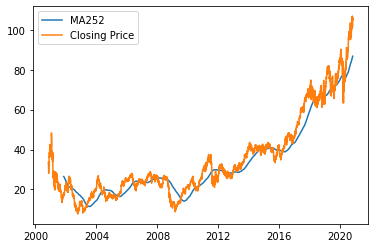

In [ ]:
plt.plot(movingAverage.iloc[:,0], label = 'MA252')
plt.plot(df_close.iloc[:,0], label = 'Closing Price')
plt.legend()
plt.show()

In [ ]:
## Exporting the Dataset
from google.colab import drive
drive.mount('drive')

movingAverage.to_csv('MovingAverage.csv')
!cp MovingAverage.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

# Linear Regression

### PCA

First, we perform PCA on our full features dataset to feed into our linear regression. 

In [ ]:
#Dataset we are compressing, column level 0 = Stock, column level 1 = feature
raw_df = df.drop(columns = ['Unnamed: 0','Close']).set_index(['Date' , 'Index']).unstack(level = 1).stack(level = 0).unstack()
raw_df = raw_df.dropna(axis = 1)
raw_df.head()

Index               A                        ...       ZION                    
             Adjusted       High        Low  ...        Low      Open    Volume
Date                                         ...                               
2000-11-03  28.999939  34.111229  32.770027  ...  56.062500  56.75000  334100.0
2000-11-06  28.728903  33.574749  32.814735  ...  56.390625  57.50000  360900.0
2000-11-07  28.457884  33.127682  32.591202  ...  56.671875  57.65625  342300.0
2000-11-08  27.489923  33.798283  31.428827  ...  56.375000  57.25000  536800.0
2000-11-09  26.986589  31.920601  29.729971  ...  56.875000  57.43750  472200.0

[5 rows x 1910 columns]

In [ ]:
raw_df = raw_df.to_numpy()
raw_df.shape

(5027, 1910)

How many principal components to keep?

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#Scaling the data
raw_df_scaled = MinMaxScaler().fit_transform(raw_df)

#Performing PCA ~ Reducing Dimensionality
PCA = PCA(n_components=382)
PCA_df = PCA.fit_transform(raw_df_scaled)

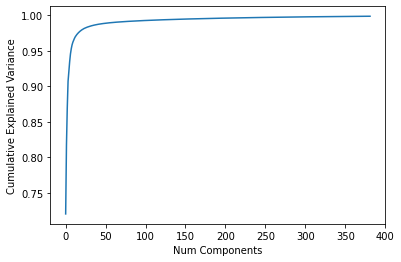

In [ ]:
plt.plot(np.cumsum(PCA.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative Explained Variance');

Storing the stock names, and dates

In [ ]:
dates = df_close.index
stocks = df_close.columns
PC_labs = []
for i in range(PCA_df.shape[1]):
  lab = "PC" + str(i+1)
  PC_labs.append(lab)

### Linear Regression Prediction Functions

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

#Using the full features dataset, the closing prices; we are able to fit a line over a specified time period
def predict_prices(raw_df, close, time, lookback, forward, stock_num):
  
  #PCA
  pca1 = PCA(n_components = 10)
  pca2 = PCA(n_components = 10)


  #Training data = t - forward - lookback
  X_train = raw_df[time-forward-lookback:time-forward,:]
  X_train = MinMaxScaler().fit_transform(X_train)
  X_train = pca1.fit_transform(X_train)
  y_train = close.iloc[time-forward+1:time+1,stock_num]

  #Testing = t - lookback
  X_test = raw_df[time-lookback:time,:]
  X_test = MinMaxScaler().fit_transform(X_test)
  X_test = pca2.fit_transform(X_test)
  y_test = close.iloc[time+1 : time+forward+1, stock_num]

  LR = LinearRegression()
  LR.fit(X_train, y_train)
  predicted = LR.predict(X_test)
  # print(mean_squared_error(y_test,predicted))

  return predicted, y_test

In [ ]:
#This function creates the entire table of features
def construct_prediction_tab(full_features_df,closing_prices_df):
  predictions = []
  actuals = [] 
  
  for stocks in range(closing_prices_df.shape[1]):
    stock_predictions = []
    stock_actuals = []
    
    for dates in range(60, df_close.shape[0], 30): 
      pred, act = predict_prices(full_features_df, closing_prices_df, dates, 30, 30, stocks)
      stock_predictions.append(pred)
      stock_actuals.append(act)

    import numpy as np
    stock_predictions = np.concatenate(stock_predictions)
    stock_actuals = np.concatenate(stock_actuals)

    predictions.append(stock_predictions)
    actuals.append(stock_actuals)

  return predictions, actuals

### Making Predictions

In [ ]:
pred, act = construct_prediction_tab(raw_df, df_close)

### Creating Dataframe for Predictions and Actuals

In [ ]:
# Need to get rid of 60 days for initial prediction window
final_actuals = pd.DataFrame(data = act, index=stocks, columns = dates[61:]).transpose()
final_preds = pd.DataFrame(data = pred, index = stocks).transpose() #Trimming because it predicts extra dates into future

In [ ]:
final_preds = final_preds.iloc[:4966,:]
final_preds.index = dates[61:]

In [ ]:
final_actuals.head()

Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-02-02,37.339054,0.368304,12.2750,25.453125,20.429480,21.78125,55.200001,14.580953,45.759800,8.796875,40.160000,43.299999,58.000000,14.9250,1727.800049,46.250000,27.020000,25.7500,12.190,8.0750,40.250000,9.46875,23.87500,23.889999,3.887407,69.9375,35.330002,14.3750,2.859375,34.709999,2.940000,26.038961,35.124886,5.82500,35.750000,23.620001,1.666667,48.000000,53.610001,42.110683,...,1.71,11.30,20.712500,15.2750,29.670000,13.2425,61.099998,16.809999,23.559999,13.986555,8.210923,8.142138,45.639999,26.857357,67.5000,59.8750,8.005025,46.764782,6.715,71.059998,42.180000,4.70,9.930,18.379999,25.120001,53.060001,24.000000,29.260626,54.759998,4.722222,6.0000,52.439999,25.549999,53.0625,41.494999,11.869792,21.765480,6.335370,24.472221,56.0000
2001-02-05,35.193134,0.360491,12.5075,26.875000,20.797577,22.68750,53.849998,14.980952,46.774921,9.015625,40.200001,44.000000,56.750000,15.7150,1763.800049,46.049999,27.490000,24.8750,12.245,8.2200,40.200001,9.87500,22.90625,24.000000,3.911111,68.3125,35.080002,14.4375,2.859375,35.380001,2.988333,26.142857,36.022202,5.53000,35.750000,23.870001,1.718750,47.750000,53.360001,42.373272,...,1.94,11.19,21.112499,15.6025,29.820000,13.1125,60.240002,17.000000,24.010000,14.315392,8.213277,8.402651,45.290001,26.703718,70.0625,61.1250,8.096380,47.214443,6.750,69.599998,41.090000,4.80,9.950,18.280001,25.680000,53.000000,23.870001,30.398123,53.840000,4.732510,6.0200,52.889999,26.010000,50.8750,42.400002,12.020833,20.869566,6.238318,24.277779,56.5000
2001-02-06,36.459229,0.377232,12.9250,29.062500,21.174654,22.00000,52.439999,14.266666,47.298344,9.234375,40.000000,44.509998,55.299999,15.5250,1731.000000,45.060001,27.510000,25.8125,12.175,8.3275,40.040001,9.87500,22.93750,24.049999,3.911111,69.8750,36.200001,15.8125,3.156250,35.150002,3.008333,26.779221,35.531914,5.70625,35.700001,24.100000,1.750000,47.450001,53.709999,41.130348,...,1.85,11.90,21.500000,15.2250,27.900000,13.2250,59.610001,17.049999,23.740000,14.468850,8.420433,8.489488,45.520000,26.572029,68.8125,66.7500,8.313350,48.923157,6.700,72.599998,41.080002,4.58,10.025,18.820000,25.445000,53.240002,24.600000,30.308321,53.200001,4.726337,6.0925,52.669998,25.809999,50.5000,42.169998,11.916667,19.472990,6.446801,24.583334,56.1875
2001-02-07,35.865520,0.370536,12.7875,29.000000,21.349726,20.15625,49.400002,15.009523,47.330067,9.000000,40.349998,44.369999,57.119999,15.8375,1738.000000,44.220001,27.959999,25.2500,12.260,8.2900,40.820000,9.87500,22.37500,23.570000,3.918519,70.6250,35.590000,15.0000,3.406250,35.180000,3.096667,27.164503,35.864941,5.47875,36.000000,24.650000,1.765625,46.480000,53.570000,40.587662,...,1.95,11.77,22.312500,15.4675,28.010000,13.1900,59.680000,17.160000,23.760000,14.709997,8.406309,8.777422,45.500000,26.601294,64.3750,62.8750,8.347608,47.619141,6.795,74.489998,42.849998,4.36,10.240,18.850000,25.370001,53.099998,24.920000,31.131510,54.660000,4.921811,6.4375,53.040001,26.549999,48.0000,42.180000,12.104167,18.208168,6.453990,25.083334,56.6875
2001-02-08,38.776825,0.370536,12.8125,28.000000,21.677423,17.96875,50.470001,15.200000,47.544193,9.156250,41.000000,45.200001,57.689999,15.8750,1714.000000,43.880001,27.379999,25.6250,12.180,8.1200,41.279999,9.40625,21.18750,24.000000,3.899259,69.8125,34.509998,14.3750,3.343750,35.500000,3.061667,26.839827,36.586494,5.23750,35.980000,24.040001,1.812500,46.400002,53.680000,41.226631,...,1.86,11.60,21.827499,15.2250,28.139999,13.2625,59.959999,17.389999,23.799999,14.534617,8.281545,8.432359,45.049999,26.528133,61.6250,65.4375,8.850062,47.799004,6.820,71.879997,41.849998,4.29,1

In [ ]:
final_preds.head()

Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-02-02,42.488975,0.386425,10.976705,18.039807,18.172351,22.345029,56.753310,13.867557,44.582959,9.780153,36.909788,38.833113,53.822549,13.998131,1616.097072,46.651447,22.955005,26.115739,12.076208,9.327942,36.050586,11.495769,27.288523,24.362449,3.999016,62.360087,36.573013,17.445537,2.958115,34.620091,2.894553,25.544977,36.233651,6.120401,36.765991,24.247906,1.595118,47.724298,54.754434,41.631816,...,2.083365,11.453391,16.870642,12.505497,25.866327,13.420691,65.118485,18.144987,24.117295,12.603213,8.478463,7.316095,45.279706,26.462379,73.555999,48.793241,8.739718,52.640242,6.853056,59.639944,37.246925,5.052462,9.376160,18.254391,24.622340,53.744612,26.178601,29.121052,57.058454,4.413766,6.306509,53.282671,23.253807,57.886048,39.511198,11.100024,21.903354,6.440618,25.218346,57.518474
2001-02-05,42.163884,0.385413,11.160127,18.257449,18.654115,22.309517,56.552685,13.945466,46.114447,10.035985,37.995590,39.548401,54.573301,14.211144,1629.493349,46.681634,22.903587,26.485856,12.158866,8.942404,36.259740,12.202550,26.836084,24.432133,3.998935,63.816125,37.021056,17.541786,2.868744,34.714727,2.868331,25.952429,35.407450,6.265683,36.378031,24.415073,1.599053,47.753759,54.252284,40.619737,...,2.128477,11.357120,17.814038,13.046970,26.448441,13.358809,63.983885,17.759233,23.487667,12.903658,8.281440,7.551612,44.691413,26.351420,74.213326,52.169699,8.640774,51.896768,7.076198,62.253076,37.933242,5.055832,9.525355,18.566577,24.512442,53.228249,26.091175,29.563841,56.054443,4.531747,6.266321,52.063372,23.790315,57.563329,39.875955,11.306913,21.623704,6.341842,25.281018,57.576885
2001-02-06,39.626574,0.389833,11.808912,17.209518,18.579722,20.940313,54.722651,14.285272,48.524052,10.508889,38.426064,39.986116,55.999936,14.402053,1610.345737,46.101525,22.926307,27.021570,12.084945,8.504060,35.779118,12.624373,26.430359,23.995506,4.090042,65.517141,38.542916,17.878539,2.645108,34.709515,2.855154,27.062323,34.859868,6.304297,36.490225,25.312296,1.659134,47.024375,54.294768,37.959051,...,2.244802,11.324064,18.629372,13.778685,27.209373,13.422568,62.877239,17.858445,23.605803,13.748730,8.067358,7.854758,44.000497,25.862941,78.387462,53.549463,8.789054,51.613302,7.575784,65.051310,38.440104,5.361302,9.536696,19.168656,24.059272,53.377233,26.170665,29.352711,55.123581,4.672689,6.260511,51.380024,23.954360,57.509930,40.024566,11.124696,21.915278,6.068232,25.370938,58.080674
2001-02-07,39.177218,0.378726,12.182041,17.949528,19.028464,21.395827,54.582691,14.349448,49.327537,10.571908,38.453742,40.062087,55.429335,14.603817,1611.211498,45.952349,22.610517,29.066267,11.905823,8.130024,35.163565,13.863037,25.969376,22.986714,4.059927,66.344263,39.831672,18.046895,2.676373,34.233994,2.825610,27.172431,34.018236,6.403884,36.435981,25.401849,1.666032,46.639021,54.208070,38.017767,...,2.237226,11.289066,19.321498,13.973710,27.419796,13.280927,61.658124,17.686956,23.383154,14.098722,7.975671,8.028820,44.089235,25.530221,81.344135,56.623546,8.811605,50.680230,7.557926,67.123231,38.668363,5.209304,9.513175,19.224788,24.015943,52.659684,26.077986,28.935040,55.132355,4.827151,6.251880,50.727134,24.046126,55.242796,40.217173,11.018591,22.012109,6.031174,25.046060,58.163690
2001-02-08,41.199323,0.361654,12.018402,19.124819,19.560702,24.301595,55.798607,13.999754,48.198304,10.287573,38.361998,40.048450,53.982751,14.744700,1636.387873,46.306581,22.215879,31.723670,11.697879,7.965755,34.760579,15.574935,25.690284,21.966650,3.961255,66.152904,39.544673,18.690163,2.865072,33.629863,2.777376,26.517261,33.398582,6.413296,36.430118,24.879618,1.625

### Exporting the Predictions

In [ ]:
from google.colab import drive
drive.mount('drive')

final_actuals.to_csv('LR_Actual_Prices.csv')
!cp LR_Actual_Prices.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

final_preds.to_csv('LR_Predicted_Prices.csv')
!cp LR_Predicted_Prices.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

# Diagnostics

In [ ]:
# Three different Prediction Windows
p1 , t1 = predict_prices(raw_df, df_close, 60, 30, 30, 5)
p2 , t2 = predict_prices(raw_df, df_close, 90, 30, 30, 5)
p3 , t3 = predict_prices(raw_df, df_close, 120, 30, 30, 5)

In [ ]:
predictions = np.concatenate([p1,p2,p3])
actuals = np.concatenate((t1,t2))

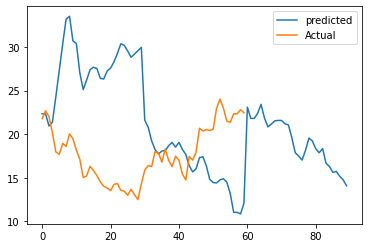

In [ ]:
#This is a plt for the first 90 days of predictions for the first stock
plt.plot(predictions, label = 'predicted')
plt.plot(actuals, label = 'Actual')
plt.legend()
plt.show()

In [ ]:
stock_predictions = []
stock_actuals = []

for i in range(60,df_close.shape[0], 30):
  pred, act = predict_prices(raw_df, df_close, i, 30, 30, 5)
  stock_predictions.append(pred)
  stock_actuals.append(act)

In [ ]:
stock_predictions = np.concatenate(stock_predictions)
stock_actuals = np.concatenate(stock_actuals)

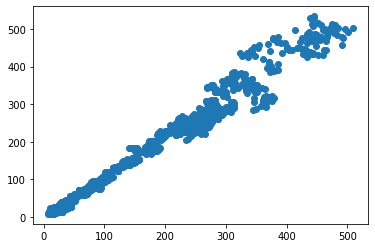

In [ ]:
# Q-Q plot for predictions vs actuals
plt.scatter(x = stock_predictions[:4966], y = stock_actuals)

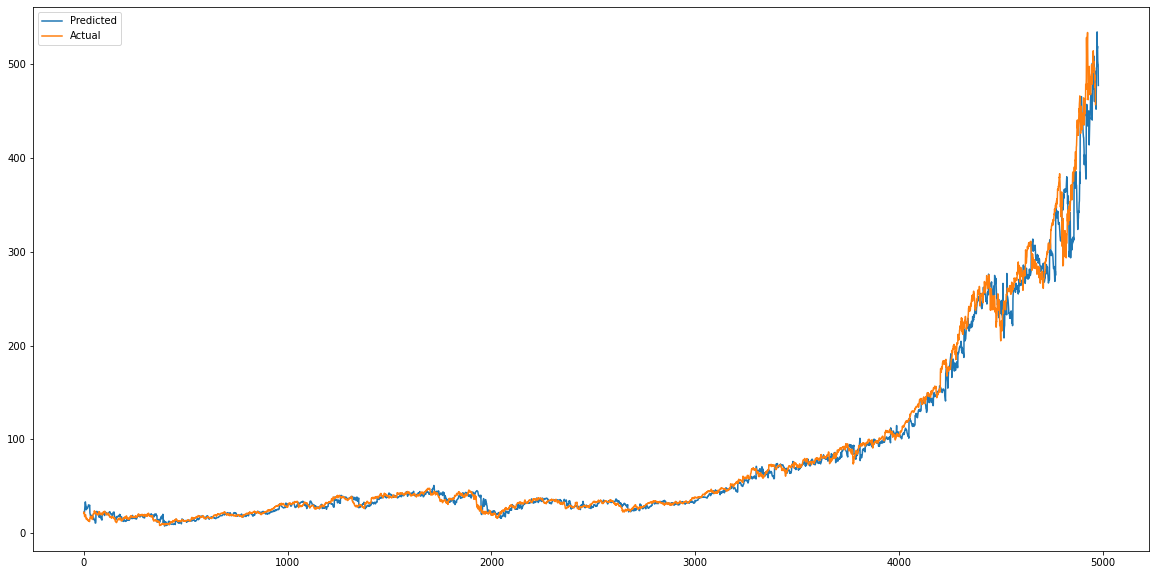

In [ ]:
#Full Prediction vs Actuals for the same stock
plt.figure(figsize=(20,10))
plt.plot(stock_predictions, label = 'Predicted')
plt.plot(stock_actuals, label = 'Actual')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_absolute_error(final_actuals, final_preds)

4.328829296411045